<span style="color:#000000; font-size:1.2em; text-align:right">Data Scientist II Technical Challenge</span>

<span style="color:#e01760; font-size:2em; align=center">Task 3: Natural Language Processing</span>

<font color="#6E6E6E" align="center">Cristina Sánchez Maíz | csmaiz@gmail.com | [LinkedIn](https://www.linkedin.com/in/csmaiz/) </font> 

**Tasks:**

Using the Customer Reviews dataset:
- Preprocess the text data (e.g., tokenization, stopword removal, stemming/lemmatization).
- Perform sentiment analysis on the reviews.
- Visualize the distribution of sentiment scores.

**Deliverables:**
- Preprocessed text data.
- Sentiment analysis results.
- Visualizations of sentiment distribution.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.clipboards import to_clipboard

# Libraries for NLP
from textblob import TextBlob
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [2]:
pd.set_option('display.max_colwidth', None) # avoid truncate columns content

In [3]:
from constants import NEGATIVE_LABEL,POSITIVE_LABEL, NEUTRAL_LABEL, PINK_RGB, REVIEWS_FILENAME, \
                      INPUT_DIR, OUTPUT_DIR,FIGURES_DIR, TASK3_DIR, FILENAMES_DIR, REVIEWS_CLEANED_FILENAME

# Load dataset

In [4]:
# Run a Linux command to get the header and the first five rows of the dataset
abs_path = os.path.join(INPUT_DIR,REVIEWS_FILENAME)
! head -n5 {abs_path}

review_id,customer_id,review_date,review_text
1,74,,
2,2,2023-10-16,"Terrible service, will not buy from here again."
3,44,2023-12-08,"Average quality, you get what you pay for."
4,6,2024-06-08,"Great product, very satisfied with the quality and performance."


In [5]:
df = pd.read_csv(abs_path,delimiter=",")
df.head(10)

,review_id,customer_id,review_date,review_text
0,1,74,NaN,NaN
1,2,2,2023-10-16,"Terrible service, will not buy from here again."
2,3,44,2023-12-08,"Average quality, you get what you pay for."
3,4,6,2024-06-08,"Great product, very satisfied with the quality and performance."
4,5,46,2024-07-30,"Very disappointed with the product, not as described."
5,6,43,2023-11-16,"Excellent service, highly recommend!"
6,7,18,2023-10-20,The item arrived damaged and customer service was unhelpful.
7,8,8,2024-03-09,Fast delivery and the product works perfectly!
8,9,57,2023-12-19,The item arrived damaged and customer service was unhelpful.
9,10,65,2024-01-13,"The service was acceptable, but could be improved."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    1010 non-null   int64 
 1   customer_id  1010 non-null   int64 
 2   review_date  989 non-null    object
 3   review_text  989 non-null    object
dtypes: int64(2), object(2)
memory usage: 31.7+ KB


In [7]:
print(df.isnull().sum())  # Count missing values in each column

review_id       0
customer_id     0
review_date    21
review_text    21
dtype: int64


In [8]:
df = df.dropna(subset=['review_text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989 entries, 1 to 1009
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    989 non-null    int64 
 1   customer_id  989 non-null    int64 
 2   review_date  989 non-null    object
 3   review_text  989 non-null    object
dtypes: int64(2), object(2)
memory usage: 38.6+ KB


# Explore the dataset

In [9]:
df.describe(include=[np.number])

,review_id,customer_id
count,989.000000,989.000000
mean,496.495450,51.189080
std,291.310937,28.358778
min,2.000000,1.000000
25%,244.000000,28.000000
50%,496.000000,53.000000
75%,748.000000,75.000000
max,1000.000000,100.000000


In [10]:
# Identifiers are stored as object to avoid using them in operations and visualizations
# Using integers as data types improve performance and storage efficiency but since the dataset is small we can use object type 
ID_COLUMNS = ["customer_id", "review_id"]
print("The dataset contains {} id columns: {}".format(len(ID_COLUMNS), ",".join(ID_COLUMNS)))

The dataset contains 2 id columns: customer_id,review_id


In [11]:
for col_ in ID_COLUMNS:
    df[col_] = df[col_].astype(object)
    print("Column '{}' has {} duplicates values".format(col_,
                                  df[col_].duplicated().sum()))

Column 'customer_id' has 889 duplicates values
Column 'review_id' has 9 duplicates values


<font color="black"> Notes on the uniqueness of the identifiers: </font>

- Column `customer_id` is allowed to appear more than once since a customer can perform more than one transaction
- Each review is assigned an unique identifier and, therefore, column `review_id` must not have duplicated values. `review_id` is the primary key in the reviews dataset.

In [12]:
# First of all, take rid of duplicated rows and repeat the check
df = df.drop_duplicates()
for col_ in ID_COLUMNS:
    print("Column '{}' has {} duplicates values".format(col_,
                                  df[col_].duplicated().sum()))

Column 'customer_id' has 880 duplicates values
Column 'review_id' has 0 duplicates values


# Preprocess the text data

<img src="../images/preprocessing.png" align="center" style="float">

* Tokenization breaks text into individual words.
* Stopword removal eliminates common words with little meaning.
* Stemming reduces words to their root form (simpler).
* Lemmatization reduces words to their root form considering context (more accurate).


<div class="alert alert-block alert-info">
<b>Only once:</b> Download necessary NLTK data
    
* punkt: sentence tokenizer. This model is used to split text sentences into individual words (tokens). It's crucial for most NLP tasks that involve analyzing words.
    
* stopwords: English stopwords. Stopwords are common words like "the", "and", "in" that carry little meaning on their own. Removing them can improve the efficiency and accuracy of NLP models by focusing on more content-rich words.
    
* wordnet: WordNet lexical database. WordNet is a comprehensive resource that contains information about English words, including synonyms, antonyms, hyponyms (more specific words), and hypernyms (broader categories). It's used for lemmatization.
    
</div>

In [13]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('vader_lexicon')

In [14]:

# This function converts the text to lower-case, remove punctuation and stopwords, tokenize and lemmatize.
def preprocess_text(text):
    
    text = text.lower() # Lowercase
    words = nltk.word_tokenize(text) # Tokenization

    # Stop word removal + punctuation removal + lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [
        lemmatizer.lemmatize(word) for word in words
        if word.isalpha() and word not in stop_words
    ]
    return ' '.join(words)

df['preprocessed_review'] = df['review_text'].apply(preprocess_text)

df[["review_text", "preprocessed_review"]].head(10) 


,review_text,preprocessed_review
1,"Terrible service, will not buy from here again.",terrible service buy
2,"Average quality, you get what you pay for.",average quality get pay
3,"Great product, very satisfied with the quality and performance.",great product satisfied quality performance
4,"Very disappointed with the product, not as described.",disappointed product described
5,"Excellent service, highly recommend!",excellent service highly recommend
6,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful
7,Fast delivery and the product works perfectly!,fast delivery product work perfectly
8,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful
9,"The service was acceptable, but could be improved.",service acceptable could improved
10,"Decent product, but there are better options available.",decent product better option available


# Sentiment Analysis



- **Lexicon-Based Methods:**
Typically benefit from preprocessing: Stop word removal and punctuation removal can improve performance by focusing on the core words.
- **Machine Learning Models (NNS)**
Almost always benefit from preprocessing: Tokenization, stop word removal, and stemming/lemmatization are essential for converting text into numerical representations that models can understand.
- **Large Language Models (LLMs)**
Less sensitive to preprocessing: LLMs are often trained on massive amounts of raw text and can handle various text formats.


## Lexicon-based methods

Rely on sentiment lexicons (pre-built dictionaries of words and their associated sentiment scores).

In [15]:


# vader_sentiment_scores containing a dictionary with four keys: 'neg', 'neu', 'pos', and 'compound'. 
# The 'compound' score is a normalized sentiment score between -1 (extremely negative) and 1 (extremely positive).
def get_vader_score(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)['compound']
    return sentiment

def get_textblob_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def assign_vader_label(score, neutral=False):
    label =  POSITIVE_LABEL if score >= 0.05 else NEGATIVE_LABEL
    return label if not neutral or abs(score) > 0.15 else NEUTRAL_LABEL

def assign_textblob_label(score, neutral=False):
    label =  POSITIVE_LABEL if score >= 0.05 else NEGATIVE_LABEL
    return label if not neutral or abs(score) > 0.15 else NEUTRAL_LABEL
    
df['vader_score'] = df['preprocessed_review'].apply(get_vader_score)
df['textblob_score'] = df['preprocessed_review'].apply(get_textblob_score)

df['vader_label'] = df['vader_score'].apply(assign_vader_label)
df['textblob_label'] = df['textblob_score'].apply(assign_textblob_label)


df['vader_label_3categ'] = df['vader_score'].apply(assign_vader_label, neutral=True)
df['textblob_label_3categ'] = df['textblob_score'].apply(assign_textblob_label, neutral=True)

df[["review_text", "preprocessed_review", "vader_score", "textblob_score", "vader_label", "textblob_label", "vader_label_3categ", "textblob_label_3categ"]].drop_duplicates()

,review_text,preprocessed_review,vader_score,textblob_score,vader_label,textblob_label,vader_label_3categ,textblob_label_3categ
1,"Terrible service, will not buy from here again.",terrible service buy,-0.4767,-1.000000,negative,negative,negative,negative
2,"Average quality, you get what you pay for.",average quality get pay,-0.1027,-0.150000,negative,negative,neutral,neutral
3,"Great product, very satisfied with the quality and performance.",great product satisfied quality performance,0.7845,0.650000,positive,positive,positive,positive
4,"Very disappointed with the product, not as described.",disappointed product described,-0.4767,-0.750000,negative,negative,negative,negative
5,"Excellent service, highly recommend!",excellent service highly recommend,0.7574,0.580000,positive,positive,positive,positive
6,The item arrived damaged and customer service was unhelpful.,item arrived damaged customer service unhelpful,-0.4404,0.000000,negative,negative,negative,neutral
7,Fast delivery and the product works perfectly!,fast delivery product work perfectly,0.6369,0.600000,positive,positive,positive,positive
9,"The service was acceptable, but could be improved.",service acceptable could improved,0.6597,0.000000,positive,negative,positive,neutral
10,"Decent product, but there are better options available.",decent product better option available,0.4404,0.355556,positive,positive,positive,positive
13,"Poor quality, would not recommend.",poor quality would recommend,-0.1531,-0.400000,negative,negative,negative,negative


## ML models

Generally more accurate than lexicon-based methods but require labeled data.

Examples: Naive Bayes, SVMs, Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM).

Since I do not have labeled data, I discard this approach and try an unsupervised classifier in next section


## Large language model

In [16]:
#import os
#os.environ["http_proxy"]=""
#os.environ["https_proxy"]=""

In [17]:
%%time

# Load the pre-trained model - https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english
# The "distilbert-base-uncased-finetuned-sst-2-english" model is specifically trained for binary sentiment analysis (positive or negative)
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


'''
This function encapsulates the process of converting raw text into a format suitable for the BERT model, 
obtaining the model's prediction, and mapping the numerical prediction to a human-readable 
sentiment label.
'''
def get_bert_score(texts):
    # convert the text to a compatible BERT format and set the output a PyTorch tensor.
    inputs = tokenizer(texts, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    #The model's output is a tensor of logits, e.g., tensor([[ 3.6704, -3.0642]])
    # representing the unnormalized scores for each class (positive or negative in this case). 
    # The argmax() function 
    # and item() converts it to a Python integer.
    logits = outputs.logits
    print(texts)
    print("logits", logits)
    predicted_labels  = logits.argmax(-1).tolist() # finds the index of the maximum value (the most probable class), 
    print("predicted_labels", predicted_labels, logits.argmax())
    print("softmax", torch.softmax(logits, dim=-1))
    scores = torch.softmax(logits, dim=-1)[:, 1].tolist() # Re-scales to [0,1] and sum to 1.
    print("scores", scores)
    label_map = {0: "negative", 1: "positive"}
    print("-----")
    return [(label_map[label], score) for label, score in zip(predicted_labels, scores)]

df['bert_pred'] = df['review_text'].apply(get_bert_score)
df['bert_score'] = df['bert_pred'].apply(lambda bb: bb[0][1])
df['bert_label'] = df['bert_pred'].apply(lambda bb: bb[0][0])
df['bert_label_3categ'] = df.apply(lambda row: "neutral" if row["bert_score"]>0.01 and row["bert_score"]<0.03 else row["bert_label"], axis=1)


Terrible service, will not buy from here again.
logits tensor([[ 3.6704, -3.0642]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9988, 0.0012]])
scores [0.0011877164943143725]
-----
Average quality, you get what you pay for.
logits tensor([[-0.1297,  0.2418]])
predicted_labels [1] tensor(1)
softmax tensor([[0.4082, 0.5918]])
scores [0.5918025374412537]
-----
Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4277e-04, 9.9986e-01]])
scores [0.9998571872711182]
-----
Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
The item arrived damaged and customer servi

Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4277e-04, 9.9986e-01]])
scores [0.9998571872711182]
-----
Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]])
predicted_labels [1] tensor(1)
softmax tensor([[1.1338e-04, 9.9989e-01]])
scores [0.9998866319656372]
-----
The service was acceptable, but c

The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
Decent product, but there are better options available.
logits tensor([[-1.9398,  1.9151]])
predicted_labels [1] tensor(1)
softmax tensor([[0.0207, 0.9793]])
scores [0.9792628288269043]
-----
Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
Decent product, but t

Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
Average quality, you get what you pay for.
logits tensor([[-0.1297,  0.2418]])
predicted_labels [1] tensor(1)
softmax tensor([[0.4082, 0.5918]])
scores [0.5918025374412537]
-----
Terrible service, will not buy from here again.
logits tensor([[ 3.6704, -3.0642]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9988, 0.0012]])
scores [0.0011877164943143725]
-----
Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]])
predicted_labels [1] tensor(1)
softmax tensor([[1.1338e-04, 9.9989e-01]])
scores [0.9998866319656372]
-----
Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]])
pred

Decent product, but there are better options available.
logits tensor([[-1.9398,  1.9151]])
predicted_labels [1] tensor(1)
softmax tensor([[0.0207, 0.9793]])
scores [0.9792628288269043]
-----
The product exceeded my expectations, very happy with the purchase.
logits tensor([[-4.2609,  4.5720]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4583e-04, 9.9985e-01]])
scores [0.9998540878295898]
-----
Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
Terrible service, will not buy from here again.
logits tensor([[ 3.6704, -3.0642]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9988, 0.0012]])
scores [0.0011877164943143725]
-----
Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
Poor quality, would not re

Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4277e-04, 9.9986e-01]])
scores [0.9998571872711182]
-----
The product is okay, nothing special.
logits tensor([[ 2.3129, -1.9340]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9859, 0.0141]])
scores [0.014106560498476028]
-----
Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
The product exceeded my expectations, very happy with the purchase.
logits tensor([[-4.2609,  4.5720]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4583e-04, 9.9985e-01]])
scores [0.9998540878295898]
-----
Average quality, you get what you pay for.

Average quality, you get what you pay for.
logits tensor([[-0.1297,  0.2418]])
predicted_labels [1] tensor(1)
softmax tensor([[0.4082, 0.5918]])
scores [0.5918025374412537]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
Fast delivery and the product works perfectly!
logits tensor([[-4.2885,  4.6677]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2892e-04, 9.9987e-01]])
scores [0.999871015548706]
-----
The product works fine, but took a long time to arrive.
logits tensor([[ 2.8918, -2.5381]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9956, 0.0044]])
scores [0.004364439286291599]
-----
The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
Poor quality, would not recommend

Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4277e-04, 9.9986e-01]])
scores [0.9998571872711182]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
Very disappo

Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4277e-04, 9.9986e-01]])
scores [0.9998571872711182]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4277e-04, 9.9986e-01]])
scores [0.9998571872711182]
-----
Decent product, but there are better options available.
logits tensor([[-1.9398,  1.9151]])
predicted_labels [1] tensor(1)
softmax tensor([[0.0207, 0.9793]])
scores [0.9792628288269043]
-----
Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
Very disappointe

Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]])
predicted_labels [1] tensor(1)
softmax tensor([[1.1338e-04, 9.9989e-01]])
scores [0.9998866319656372]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]])
predicted_labels [1] tensor(1)
softmax tensor([[1.1338e-04, 9.9989e-01]])
scores [0.9998866319656372]
-----
Terrible service, will not buy from here again.
logits tensor([[ 3.6704, -3.0642]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9988, 0.0012]])
scores [0.0011877164943143725]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
Poor quality, would not recommend.
logits tenso

The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]])
predicted_labels [1] tensor(1)
softmax tensor([[1.1338e-04, 9.9989e-01]])
scores [0.9998866319656372]
-----
Average quality, you get what you pay for.
logits tensor([[-0.1297,  0.2418]])
predicted_labels [1] tensor(1)
softmax tensor([[0.4082, 0.5918]])
scores [0.5918025374412537]
-----
The service was acceptable, but could be 

Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
Fast delivery and the product works perfectly!
logits tensor([[-4.2885,  4.6677]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2892e-04, 9.9987e-01]])
scores [0.999871015548706]
-----
Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
The product is okay, nothing special.
logits tensor([[ 2.3129, -1.9340]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9859, 0.0141]])
scores [0.014106560498476028]
-----
Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]

The service was acceptable, but could be improved.
logits tensor([[ 1.9450, -1.5865]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9716, 0.0284]])
scores [0.028428703546524048]
-----
The service was acceptable, but could be improved.
logits tensor([[ 1.9450, -1.5865]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9716, 0.0284]])
scores [0.028428703546524048]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
The product exce

The product works fine, but took a long time to arrive.
logits tensor([[ 2.8918, -2.5381]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9956, 0.0044]])
scores [0.004364439286291599]
-----
The service was acceptable, but could be improved.
logits tensor([[ 1.9450, -1.5865]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9716, 0.0284]])
scores [0.028428703546524048]
-----
The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
The service was acceptable, but could be improved.
logits tensor([[ 1.9450, -1.5865]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9716, 0.0284]])
scores [0.028428703546524048]
-----
The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
The produc

Terrible service, will not buy from here again.
logits tensor([[ 3.6704, -3.0642]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9988, 0.0012]])
scores [0.0011877164943143725]
-----
The product is okay, nothing special.
logits tensor([[ 2.3129, -1.9340]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9859, 0.0141]])
scores [0.014106560498476028]
-----
Average quality, you get what you pay for.
logits tensor([[-0.1297,  0.2418]])
predicted_labels [1] tensor(1)
softmax tensor([[0.4082, 0.5918]])
scores [0.5918025374412537]
-----
The product is okay, nothing special.
logits tensor([[ 2.3129, -1.9340]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9859, 0.0141]])
scores [0.014106560498476028]
-----
Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
p

Decent product, but there are better options available.
logits tensor([[-1.9398,  1.9151]])
predicted_labels [1] tensor(1)
softmax tensor([[0.0207, 0.9793]])
scores [0.9792628288269043]
-----
Fast delivery and the product works perfectly!
logits tensor([[-4.2885,  4.6677]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2892e-04, 9.9987e-01]])
scores [0.999871015548706]
-----
Fast delivery and the product works perfectly!
logits tensor([[-4.2885,  4.6677]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2892e-04, 9.9987e-01]])
scores [0.999871015548706]
-----
The product works fine, but took a long time to arrive.
logits tensor([[ 2.8918, -2.5381]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9956, 0.0044]])
scores [0.004364439286291599]
-----
The product works fine, but took a long time to arrive.
logits tensor([[ 2.8918, -2.5381]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9956, 0.0044]])
scores [0.004364439286291599]
-----
Amazing quality, will definitely buy aga

The product exceeded my expectations, very happy with the purchase.
logits tensor([[-4.2609,  4.5720]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4583e-04, 9.9985e-01]])
scores [0.9998540878295898]
-----
Fast delivery and the product works perfectly!
logits tensor([[-4.2885,  4.6677]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2892e-04, 9.9987e-01]])
scores [0.999871015548706]
-----
The product is okay, nothing special.
logits tensor([[ 2.3129, -1.9340]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9859, 0.0141]])
scores [0.014106560498476028]
-----
Average quality, you get what you pay for.
logits tensor([[-0.1297,  0.2418]])
predicted_labels [1] tensor(1)
softmax tensor([[0.4082, 0.5918]])
scores [0.5918025374412537]
-----
The service was acceptable, but could be improved.
logits tensor([[ 1.9450, -1.5865]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9716, 0.0284]])
scores [0.028428703546524048]
-----
The product is okay, nothing special.
logits tensor([[

Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]])
predicted_labels [1] tensor(1)
softmax tensor([[1.1338e-04, 9.9989e-01]])
scores [0.9998866319656372]
-----
Decent product, but there are better options available.
logits tensor([[-1.9398,  1.9151]])
predicted_labels [1] tensor(1)
softmax tensor([[0.0207, 0.9793]])
scores [0.9792628288269043]
-----
The product exceeded my expectations, very happy with the purchase.
logits tensor([[-4.2609,  4.5720]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4583e-04, 9.9985e-01]])
scores [0.9998540878295898]
-----
The product broke after one use, very unhappy.
logits tensor([[ 4.6534, -3.7225]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9977e-01, 2.3031e-04]])
scores [0.00023030857846606523]
-----
The product

Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
Decent product, but there are better options available.
logits tensor([[-1.9398,  1.9151]])
predicted_labels [1] tensor(1)
softmax tensor([[0.0207, 0.9793]])
scores [0.9792628288269043]
-----
Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
The product broke after one use, very unha

The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
The service was acceptable, but could be improved.
logits tensor([[ 1.9450, -1.5865]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9716, 0.0284]])
scores [0.028428703546524048]
-----
Excellent service, highly recommend!
logits tensor([[-4.3082,  4.6635]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2694e-04, 9.9987e-01]])
scores [0.9998730421066284]
-----
Poor quality, would not recommend.
logits tensor([[ 3.9128, -3.1779]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9917e-01, 8.3216e-04]])
scores [0.000832162331789732]
-----
The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
Fast delivery and the product w

The item arrived damaged and customer service was unhelpful.
logits tensor([[ 4.6951, -3.7931]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.0584e-04]])
scores [0.00020584168669302016]
-----
The product works fine, but took a long time to arrive.
logits tensor([[ 2.8918, -2.5381]])
predicted_labels [0] tensor(0)
softmax tensor([[0.9956, 0.0044]])
scores [0.004364439286291599]
-----
Very disappointed with the product, not as described.
logits tensor([[ 4.6936, -3.7686]])
predicted_labels [0] tensor(0)
softmax tensor([[9.9979e-01, 2.1127e-04]])
scores [0.00021126502542756498]
-----
Amazing quality, will definitely buy again.
logits tensor([[-4.3777,  4.7069]])
predicted_labels [1] tensor(1)
softmax tensor([[1.1338e-04, 9.9989e-01]])
scores [0.9998866319656372]
-----
The product exceeded my expectations, very happy with the purchase.
logits tensor([[-4.2609,  4.5720]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4583e-04, 9.9985e-01]])
scores [0.9998540878295898]
-

Fast delivery and the product works perfectly!
logits tensor([[-4.2885,  4.6677]])
predicted_labels [1] tensor(1)
softmax tensor([[1.2892e-04, 9.9987e-01]])
scores [0.999871015548706]
-----
Decent product, but there are better options available.
logits tensor([[-1.9398,  1.9151]])
predicted_labels [1] tensor(1)
softmax tensor([[0.0207, 0.9793]])
scores [0.9792628288269043]
-----
The product exceeded my expectations, very happy with the purchase.
logits tensor([[-4.2609,  4.5720]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4583e-04, 9.9985e-01]])
scores [0.9998540878295898]
-----
Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4277e-04, 9.9986e-01]])
scores [0.9998571872711182]
-----
Great product, very satisfied with the quality and performance.
logits tensor([[-4.2546,  4.5995]])
predicted_labels [1] tensor(1)
softmax tensor([[1.4277e-04, 9.9986e-01]])
scores [0.99985718727111

In [18]:
df[["review_text", "bert_score", "bert_label", "bert_label_3categ"]].drop_duplicates()

,review_text,bert_score,bert_label,bert_label_3categ
1,"Terrible service, will not buy from here again.",0.001188,negative,negative
2,"Average quality, you get what you pay for.",0.591803,positive,positive
3,"Great product, very satisfied with the quality and performance.",0.999857,positive,positive
4,"Very disappointed with the product, not as described.",0.000211,negative,negative
5,"Excellent service, highly recommend!",0.999873,positive,positive
6,The item arrived damaged and customer service was unhelpful.,0.000206,negative,negative
7,Fast delivery and the product works perfectly!,0.999871,positive,positive
9,"The service was acceptable, but could be improved.",0.028429,negative,neutral
10,"Decent product, but there are better options available.",0.979263,positive,positive
13,"Poor quality, would not recommend.",0.000832,negative,negative


## Future work
- Experiment with different thresholds
- Try different LLMs
- Get labeled data and run a ML

# Sentiment analysis results

The three libraries manage to classify the reviews that have a strong positive/negative sentiment. The differences arise when the review 
- has a more impartial tone:
   * 2. Average quality, you get what you pay for.
   * 58. The product is okay, nothing special.	
- is composed of two parts, one positive and the other negative:
   * 9. The service was acceptable, but could be improved.
   * 15. The product works fine, but took a long time to arrive.

## Two categories analysis

In [19]:
df_results = df[["review_text", "vader_score", "textblob_score", "bert_score", "vader_label", "textblob_label", "bert_label"]].drop_duplicates()
os.environ["TOKENIZERS_PARALLELISM"]="false"
to_clipboard(df_results.to_html(), excel=False)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>review_text</th>
      <th>vader_score</th>
      <th>textblob_score</th>
      <th>bert_score</th>
      <th>vader_label</th>
      <th>textblob_label</th>
      <th>bert_label</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>Terrible service, will not buy from here again.</td>
      <td>-0.4767</td>
      <td>-1.000000</td>
      <td>0.001188</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Average quality, you get what you pay for.</td>
      <td>-0.1027</td>
      <td>-0.150000</td>
      <td>0.591803</td>
      <td><font color="#0341cd"> negative </font> </td>
      <td><font color="#0341cd"> negative </font> </td>
      <td><font color="#0341cd"> positive </font> </td>
    </tr>
    <tr>
      <th>3</th>
      <td>Great product, very satisfied with the quality and performance.</td>
      <td>0.7845</td>
      <td>0.650000</td>
      <td>0.999857</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Very disappointed with the product, not as described.</td>
      <td>-0.4767</td>
      <td>-0.750000</td>
      <td>0.000211</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Excellent service, highly recommend!</td>
      <td>0.7574</td>
      <td>0.580000</td>
      <td>0.999873</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>6</th>
      <td>The item arrived damaged and customer service was unhelpful.</td>
      <td>-0.4404</td>
      <td>0.000000</td>
      <td>0.000206</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Fast delivery and the product works perfectly!</td>
      <td>0.6369</td>
      <td>0.600000</td>
      <td>0.999871</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>9</th>
      <td>The service was acceptable, but could be improved.</td>
      <td>0.6597</td>
      <td>0.000000</td>
      <td>0.028429</td>        
      <td><font color="#0341cd"> positive </font> </td>
      <td><font color="#0341cd"> negative </font> </td>
      <td><font color="#0341cd"> negative </font> </td>      
    </tr>
    <tr>
      <th>10</th>
      <td>Decent product, but there are better options available.</td>
      <td>0.4404</td>
      <td>0.355556</td>
      <td>0.979263</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>13</th>
      <td>Poor quality, would not recommend.</td>
      <td>-0.1531</td>
      <td>-0.400000</td>
      <td>0.000832</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>15</th>
      <td>The product works fine, but took a long time to arrive.</td>
      <td>0.2023</td>
      <td>0.183333</td>
      <td>0.004364</td>
      <td><font color="#0341cd"> positive </font> </td>
      <td><font color="#0341cd"> positive </font> </td>
      <td><font color="#0341cd"> negative </font> </td>
    </tr>
    <tr>
      <th>16</th>
      <td>The product broke after one use, very unhappy.</td>
      <td>-0.6808</td>
      <td>-0.600000</td>
      <td>0.000230</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>28</th>
      <td>Amazing quality, will definitely buy again.</td>
      <td>0.7579</td>
      <td>0.300000</td>
      <td>0.999887</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>58</th>
      <td>The product is okay, nothing special.</td>
      <td>-0.0920</td>
      <td>0.428571</td>
      <td>0.014107</td>
      <td><font color="#0341cd"> negative </font> </td>
      <td><font color="#0341cd"> positive </font> </td>
      <td><font color="#0341cd"> negative </font> </td>
    </tr>
    <tr>
      <th>65</th>
      <td>The product exceeded my expectations, very happy with the purchase.</td>
      <td>0.5719</td>
      <td>0.800000</td>
      <td>0.999854</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
  </tbody>
</table>    

## Three categories analysis

In [20]:
df_results = df[["review_text",  "vader_score", "textblob_score", "bert_score", "vader_label_3categ", "textblob_label_3categ",
                 "bert_label_3categ"]].drop_duplicates()
to_clipboard(df_results.to_html(), excel=False)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>review_text</th>
      <th>vader_score</th>
      <th>textblob_score</th>
      <th>bert_score</th>
      <th>vader_label_3categ</th>
      <th>textblob_label_3categ</th>
      <th>bert_label_3categ</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>Terrible service, will not buy from here again.</td>
      <td>-0.4767</td>
      <td>-1.000000</td>
      <td>0.001188</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Average quality, you get what you pay for.</td>
      <td>-0.1027</td>
      <td>-0.150000</td>
      <td>0.591803</td>
      <td><font color="#0341cd"> negative-> neutral </font> </td>
      <td><font color="#0341cd"> negative-> neutral </font> </td>
      <td><font color="#0341cd"> positive </font> </td>
    </tr>
    <tr>
      <th>3</th>
      <td>Great product, very satisfied with the quality and performance.</td>
      <td>0.7845</td>
      <td>0.650000</td>
      <td>0.999857</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Very disappointed with the product, not as described.</td>
      <td>-0.4767</td>
      <td>-0.750000</td>
      <td>0.000211</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Excellent service, highly recommend!</td>
      <td>0.7574</td>
      <td>0.580000</td>
      <td>0.999873</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>6</th>
      <td>The item arrived damaged and customer service was unhelpful.</td>
      <td>-0.4404</td>
      <td>0.000000</td>
      <td>0.000206</td>
      <td><font color="#0341cd"> negative </font> </td>
      <td><font color="#0341cd"> negative-->neutral </font> </td>
      <td><font color="#0341cd"> negative </font> </td>       
    </tr>
    <tr>
      <th>7</th>
      <td>Fast delivery and the product works perfectly!</td>
      <td>0.6369</td>
      <td>0.600000</td>
      <td>0.999871</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>9</th>
      <td>The service was acceptable, but could be improved.</td>
      <td>0.6597</td>
      <td>0.000000</td>
      <td>0.028429</td>
      <td><font color="#0341cd"> positive </font> </td>
      <td><font color="#0341cd"> negative->neutral </font> </td>
      <td><font color="#0341cd"> negative->neutral </font> </td>    
    </tr>
    <tr>
      <th>10</th>
      <td>Decent product, but there are better options available.</td>
      <td>0.4404</td>
      <td>0.355556</td>
      <td>0.979263</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>13</th>
      <td>Poor quality, would not recommend.</td>
      <td>-0.1531</td>
      <td>-0.400000</td>
      <td>0.000832</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>15</th>
      <td>The product works fine, but took a long time to arrive.</td>
      <td>0.2023</td>
      <td>0.183333</td>
      <td>0.004364</td>
      <td><font color="#0341cd"> positive </font> </td>
      <td><font color="#0341cd"> positive </font> </td>
      <td><font color="#0341cd"> negative </font> </td>
    </tr>
    <tr>
      <th>16</th>
      <td>The product broke after one use, very unhappy.</td>
      <td>-0.6808</td>
      <td>-0.600000</td>
      <td>0.000230</td>
      <td>negative</td>
      <td>negative</td>
      <td>negative</td>
    </tr>
    <tr>
      <th>28</th>
      <td>Amazing quality, will definitely buy again.</td>
      <td>0.7579</td>
      <td>0.300000</td>
      <td>0.999887</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
    <tr>
      <th>58</th>
      <td>The product is okay, nothing special.</td>
      <td>-0.0920</td>
      <td>0.428571</td>
      <td>0.014107</td>
      <td><font color="#0341cd"> negative->neutral </font> </td>
      <td><font color="#0341cd"> positive </font> </td>
      <td><font color="#0341cd"> negative-->neutral </font> </td>   
    </tr>
    <tr>
      <th>65</th>
      <td>The product exceeded my expectations, very happy with the purchase.</td>
      <td>0.5719</td>
      <td>0.800000</td>
      <td>0.999854</td>
      <td>positive</td>
      <td>positive</td>
      <td>positive</td>
    </tr>
  </tbody>
</table>

* Vader classifies reviews 2 and 58 as neutral 
* Textblob has two reviews (6, 9) with score 0. With three categories review 6 is assigned a neutral sentiment what 
is clearly incorrect 
* The BERT model I applied is for binary sentiment analysis, so it would be better to use another model trained for multiclass classification.

# Sentiment Distribution Visualization

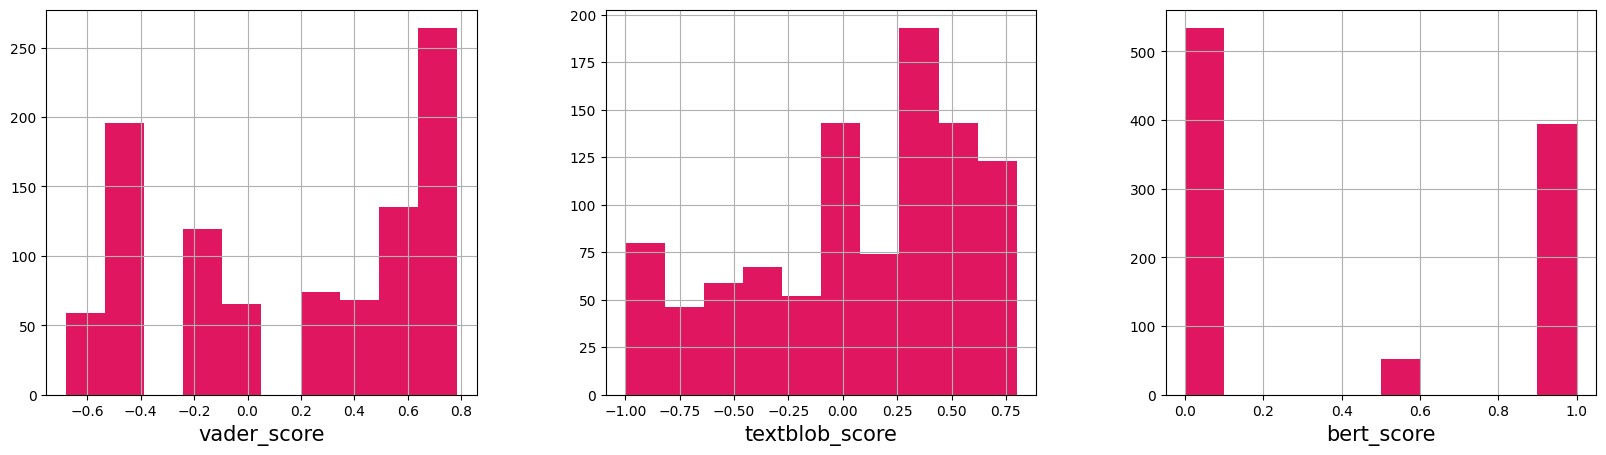

In [21]:

ax = df[["vader_score", "textblob_score", "bert_score"]].hist(bins = 10, 
                     figsize = (20,5), #width, height
                     color = '#e01760', layout=(1,3))

for axs in ax.flatten():
    axs.set_xlabel(axs.get_title(), fontsize=15)  
    axs.set_ylabel(axs.get_ylabel(), fontsize=15) 
    axs.set_title("", fontsize=28)  
    
plt.grid(True)
plt.show()

fig = ax[0][0].get_figure()



fig.savefig(os.path.join(OUTPUT_DIR,FIGURES_DIR, TASK3_DIR, "hist_sentiment_scores.png"))

In [22]:
def create_visualizations(score_col="score", label=""):
    
    fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 5) )
    fig.suptitle('Scores Distributions - {}'.format(label))


    # Histogram
    sns.histplot(data=df, x=score_col, bins=10, kde=True, ax=axs[0], color=PINK_RGB)
    axs[0].set_xlabel('')

    #plt.show()

    # Density Plot
    sns.kdeplot(data=df, x=score_col, fill=True, ax=axs[1], color=PINK_RGB, levels=15)
    #axs[0][1].set_title('Density Plot of Sentiment Scores')
    #axs[1].xlabel('Sentiment Score')
    axs[1].set_ylabel('Density')
    axs[1].set_xlabel('')

    #plt.show()

    # Box Plot
    sns.boxplot(x=df[score_col], ax=axs[2], color=PINK_RGB)
    axs[2].set_xlabel('')
    axs[2].set_ylim([-1, 1]) 
    axs[2].set_xlim([-1.25, 1.25]) 

    #axs[1][0].title('Box Plot of Sentiment Scores')
    #plt.show()


    
    plt.show()
    fig.savefig(os.path.join(OUTPUT_DIR,FIGURES_DIR, TASK3_DIR, "scores_distrib_{}.png".format(label)))

In [23]:
df.describe()

,vader_score,textblob_score,bert_score
count,980.000000,980.000000,980.000000
mean,0.172274,0.074104,0.435535
std,0.508658,0.532050,0.477814
min,-0.680800,-1.000000,0.000206
25%,-0.440400,-0.400000,0.001188
50%,0.202300,0.183333,0.028429
75%,0.659700,0.580000,0.999857
max,0.784500,0.800000,0.999887


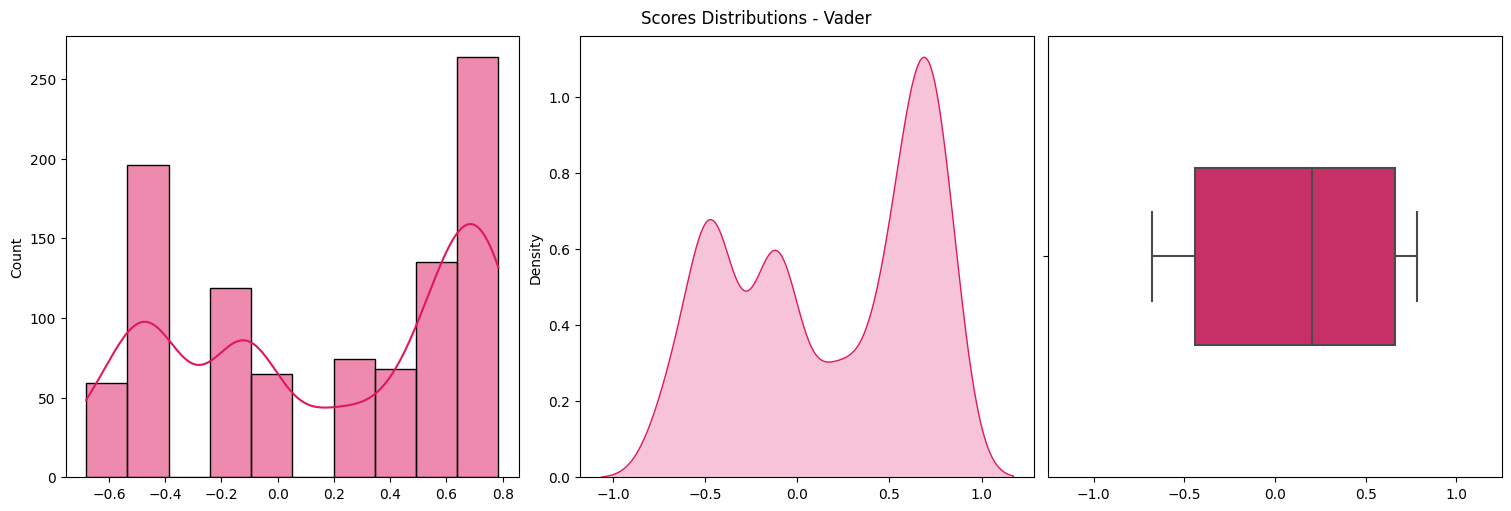

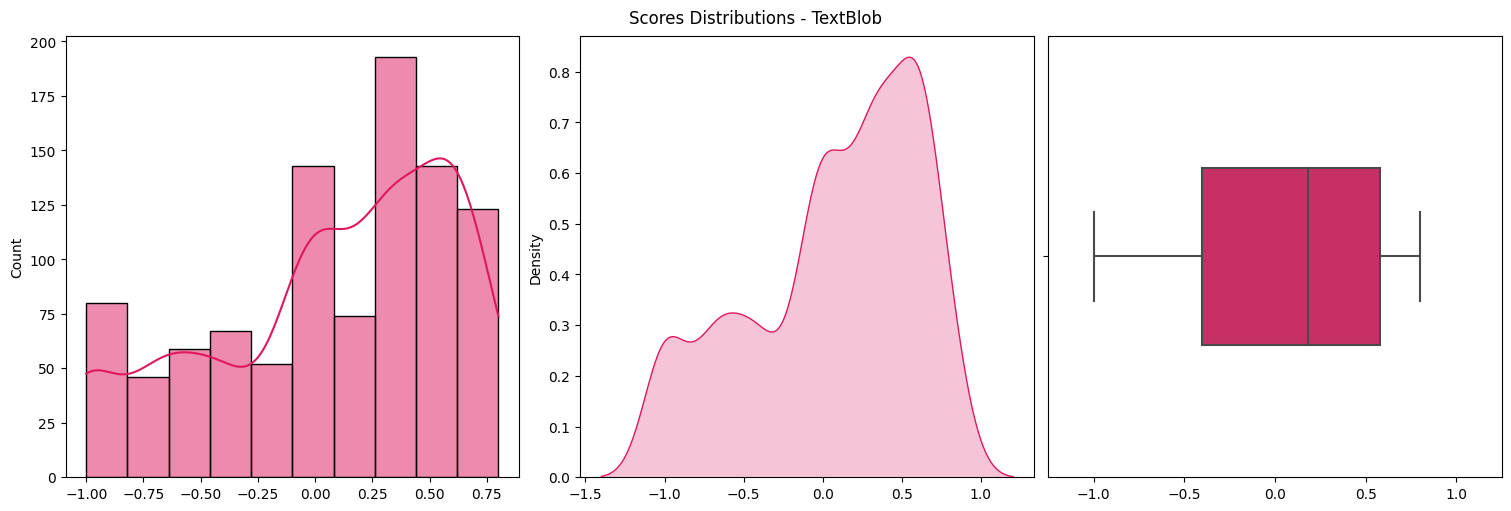

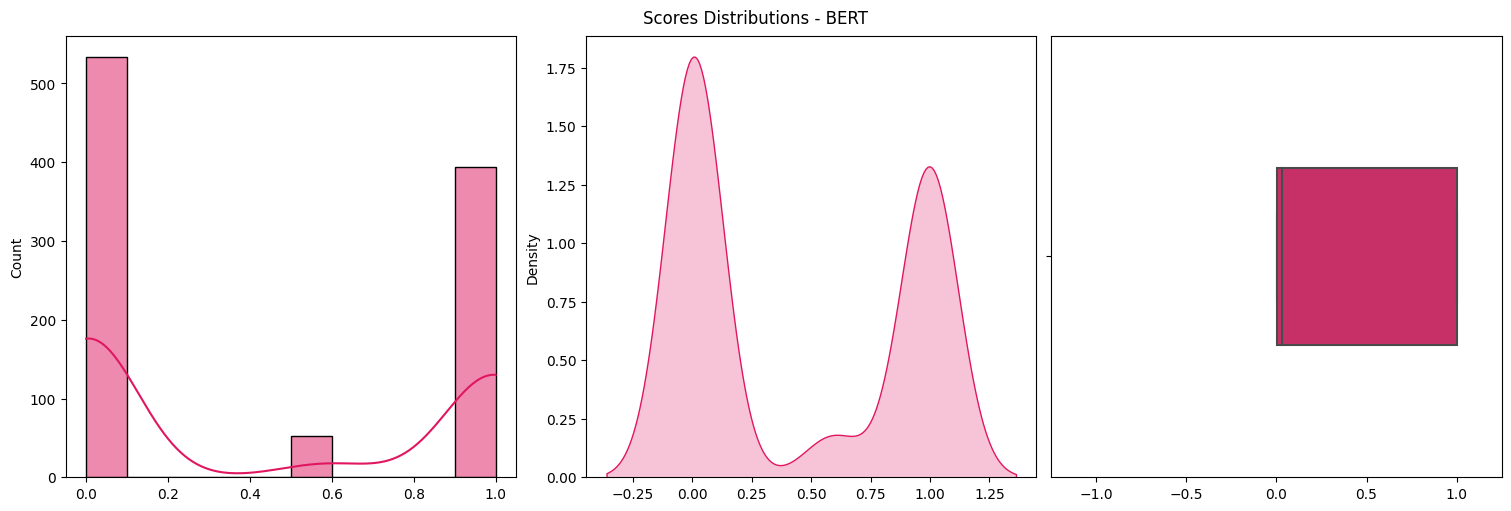

In [24]:
create_visualizations(score_col="vader_score", label="Vader")

create_visualizations(score_col="textblob_score", label="TextBlob")

create_visualizations(score_col="bert_score", label="BERT")


VADER


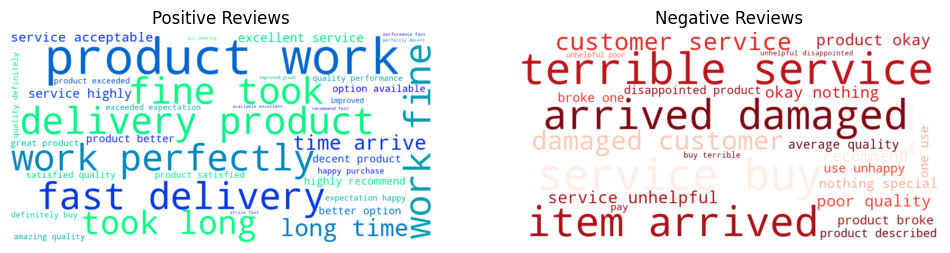

BERT


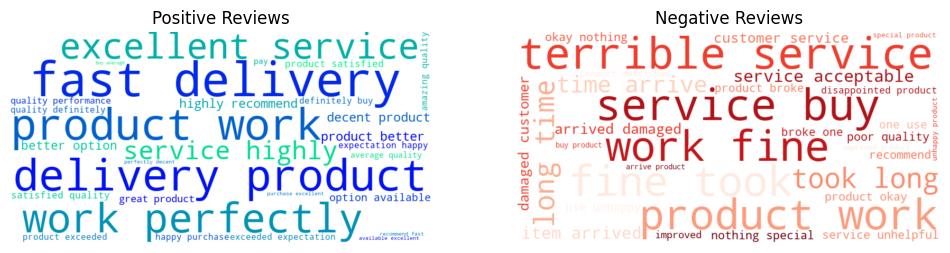

In [25]:

from wordcloud import WordCloud

def generate_word_cloud(label_col, text_col, title=""):
    positive_reviews = df[df[label_col] == POSITIVE_LABEL] # positive labels
    negative_reviews = df[df[label_col] == NEGATIVE_LABEL] # negative labels

    # Generate word clouds
    wordcloud_positive = WordCloud(width=800, height=400, background_color="white", colormap="winter").generate(' '.join(positive_reviews[text_col]))
    wordcloud_negative = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(' '.join(negative_reviews[text_col]))

    fig=plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Positive Reviews')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Negative Reviews')

    plt.show()
    fig.savefig(os.path.join(OUTPUT_DIR,FIGURES_DIR, TASK3_DIR, "wordcloud_{}.png".format(title)))
        
print("VADER")
generate_word_cloud(label_col="vader_label", text_col="preprocessed_review", title="Vader")


print("BERT")
generate_word_cloud(label_col="bert_label", text_col="preprocessed_review", title="BERT")

# Save cleaned dataframe

In [26]:
columns = ["review_text", "preprocessed_review", "vader_label", "vader_label_3categ", "bert_score", "bert_label", "bert_label_3categ"]
abs_path = os.path.join(OUTPUT_DIR, FILENAMES_DIR, REVIEWS_CLEANED_FILENAME)
df[columns].to_csv(abs_path, index=False, sep=",")
print("Saved {}".format(abs_path))

Saved ../output/cleaned_files/reviews_with_scores.csv
